<a href="https://colab.research.google.com/github/gopikasingh/gopika/blob/master/CreationOfDepthMaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [ ]:
from scipy.ndimage.filters import *
from scipy.sparse import diags
from skimage import img_as_float, img_as_ubyte
from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import rescale
from skimage.util import view_as_windows
import matplotlib.pyplot as plt
from numba import jit
import cv2

In [ ]:
imgL = cv2.imread('/content/drive/MyDrive/ImageLab/l4.png', 0)
imgR = cv2.imread('/content/drive/MyDrive/ImageLab/r4.png', 0)
imgR = cv2.resize(imgR, imgL.shape[2::-1])
print(imgL.shape)
print(imgR.shape)

(742, 623)
(742, 623)


16 5


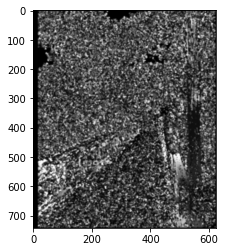

16 7


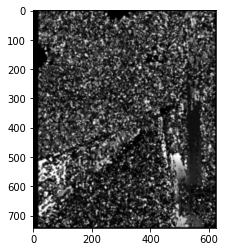

16 9


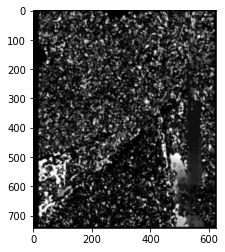

16 11


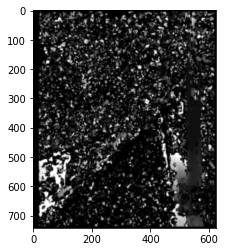

16 13


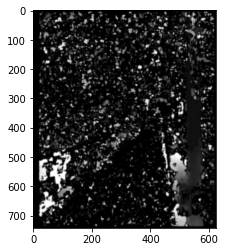

16 15


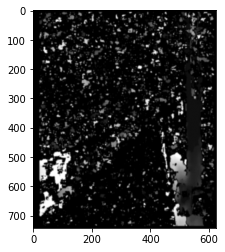

16 17


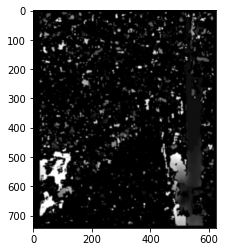

16 19


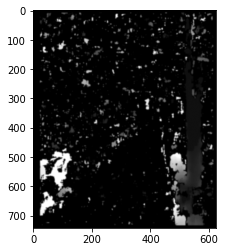

16 21


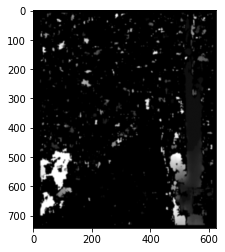

16 23


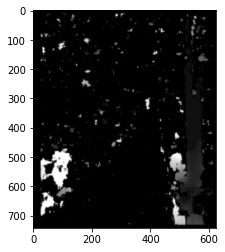

16 25


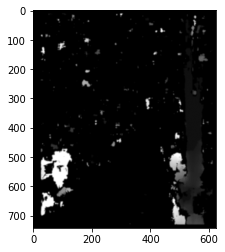

16 27


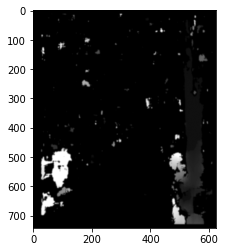

16 29


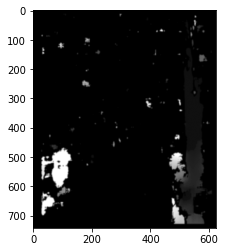

16 31


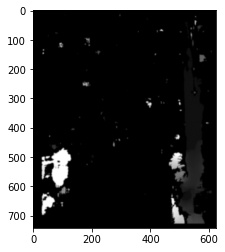

16 33


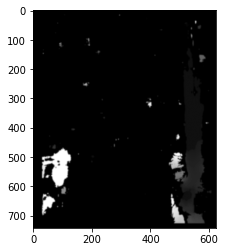

16 35


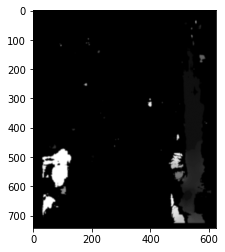

16 37


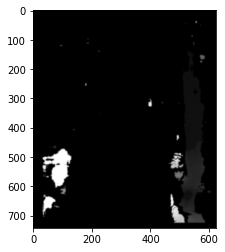

16 39


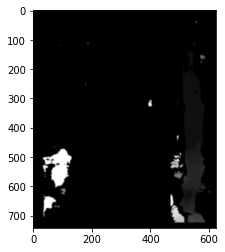

16 41


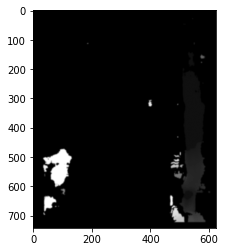

16 43


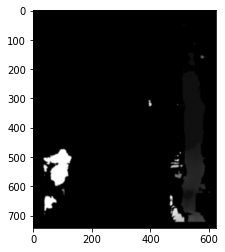

16 45


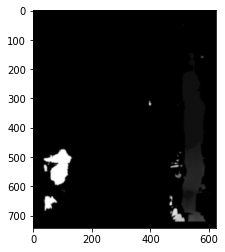

16 47


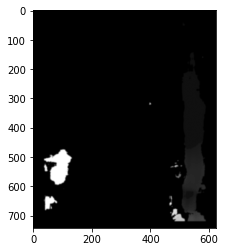

16 49


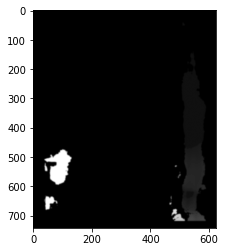

16 51


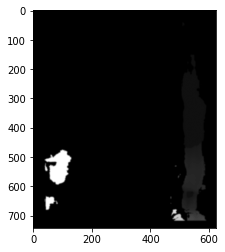

16 53


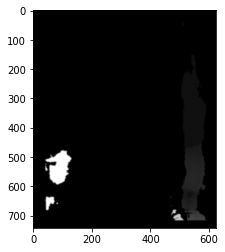

16 55


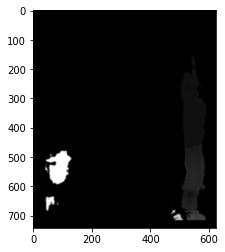

32 5


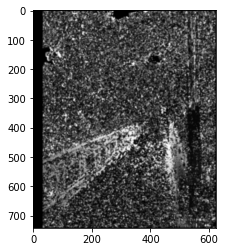

32 7


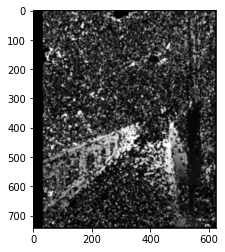

32 9


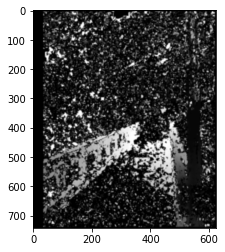

32 11


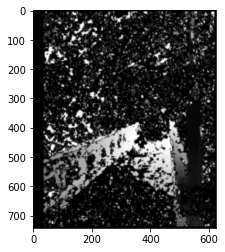

32 13


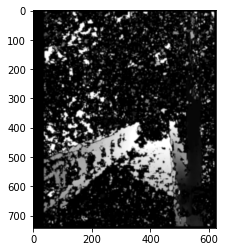

32 15


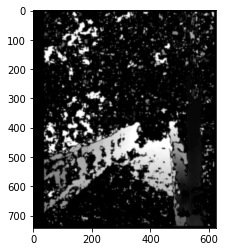

32 17


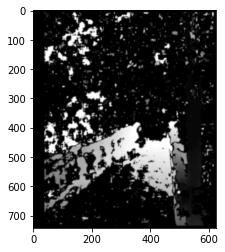

32 19


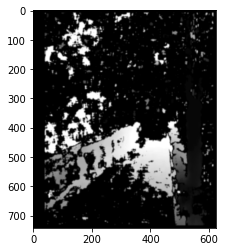

32 21


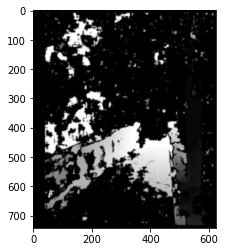

32 23


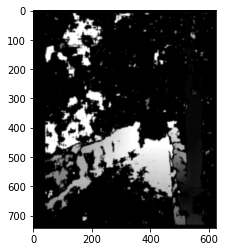

32 25


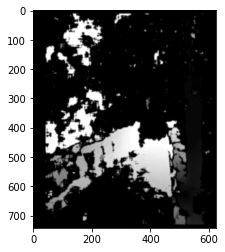

32 27


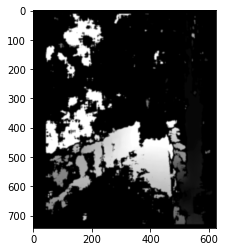

32 29


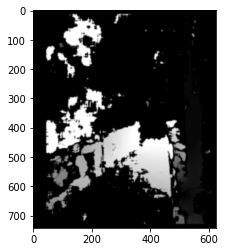

32 31


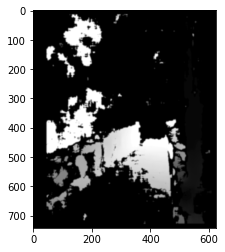

32 33


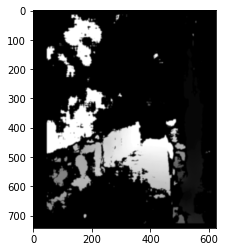

32 35


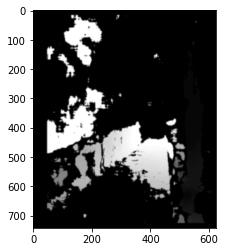

32 37


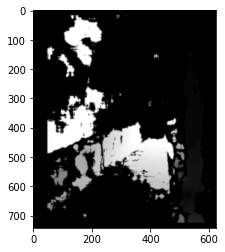

32 39


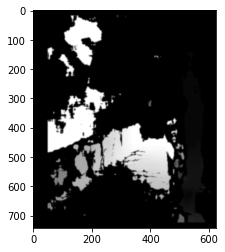

32 41


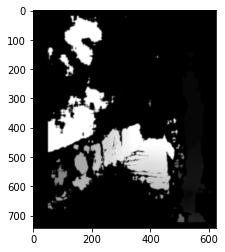

32 43


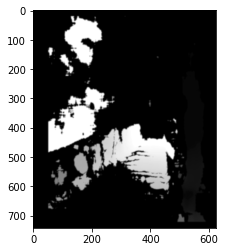

32 45


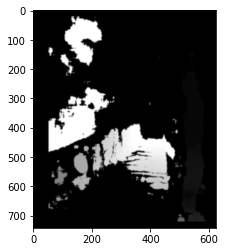

32 47


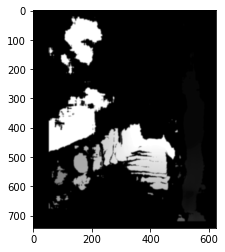

32 49


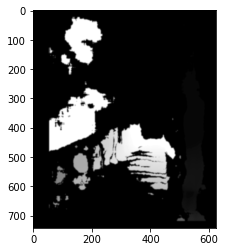

32 51


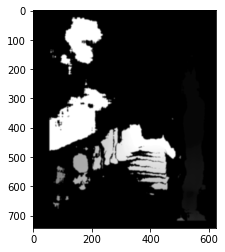

32 53


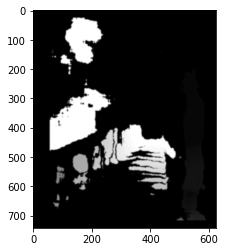

32 55


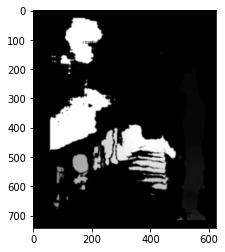

48 5


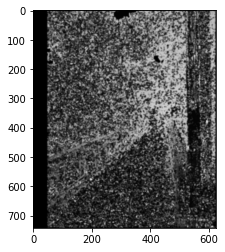

48 7


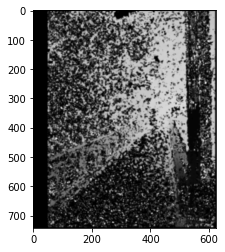

48 9


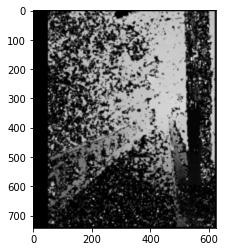

48 11


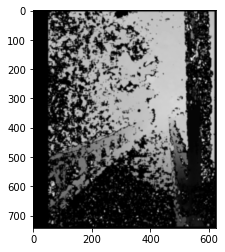

48 13


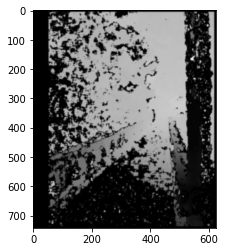

48 15


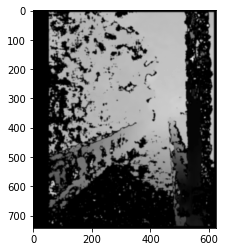

48 17


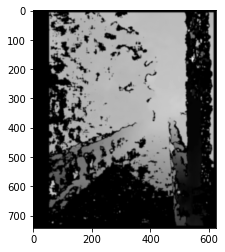

48 19


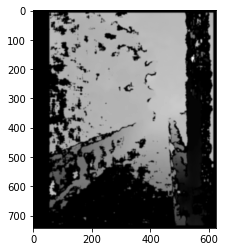

48 21


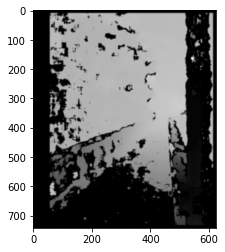

48 23


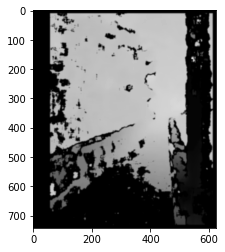

48 25


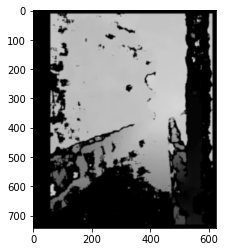

48 27


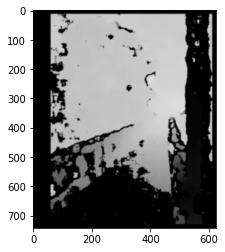

48 29


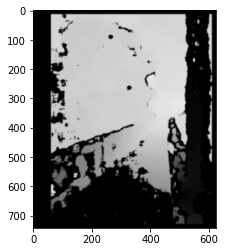

48 31


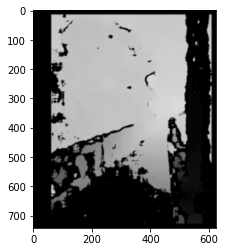

48 33


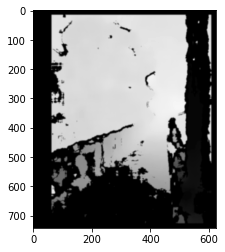

48 35


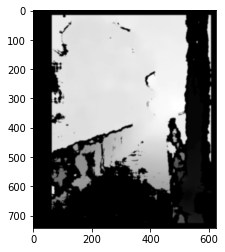

48 37


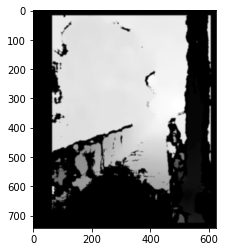

48 39


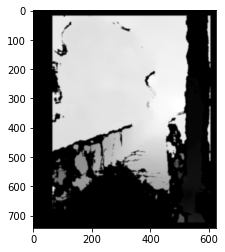

48 41


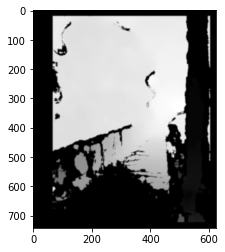

48 43


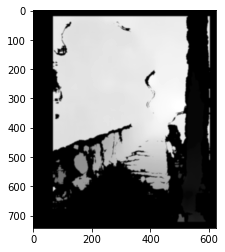

48 45


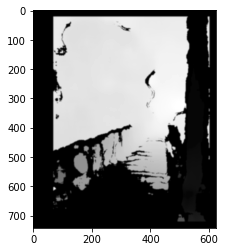

48 47


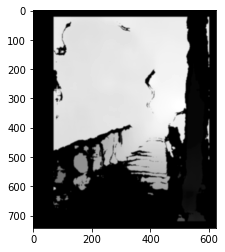

48 49


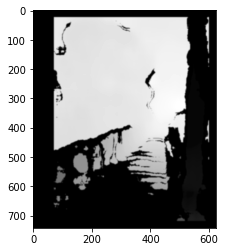

48 51


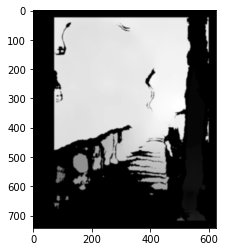

48 53


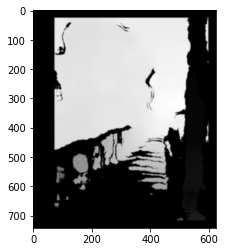

48 55


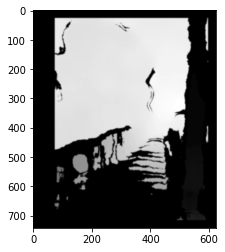

64 5


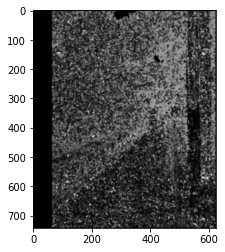

64 7


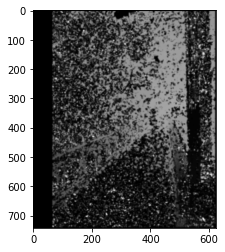

64 9


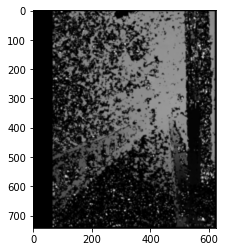

64 11


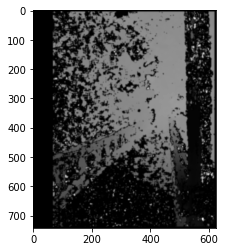

64 13


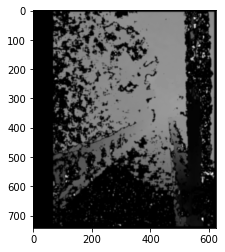

64 15


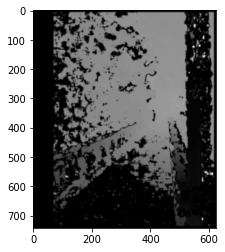

64 17


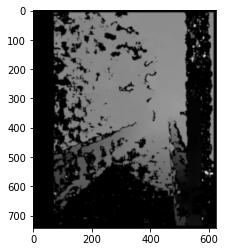

64 19


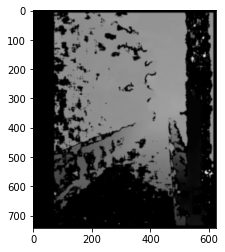

64 21


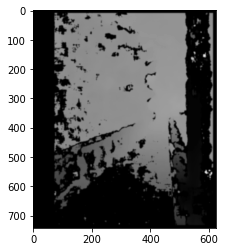

64 23


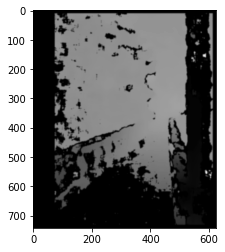

64 25


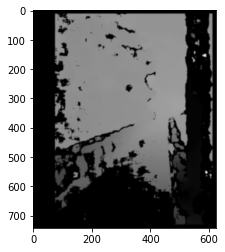

64 27


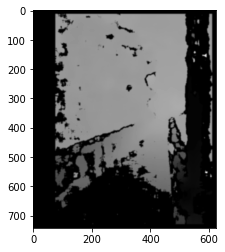

64 29


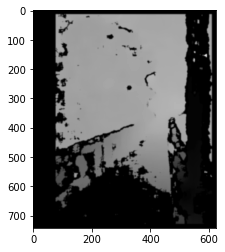

64 31


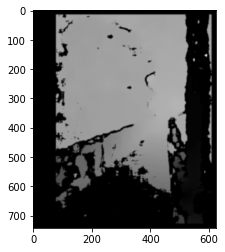

64 33


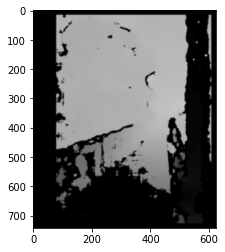

64 35


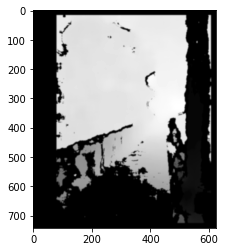

64 37


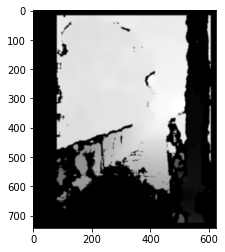

64 39


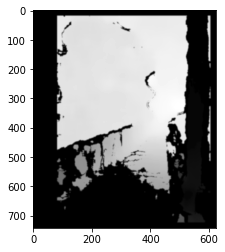

64 41


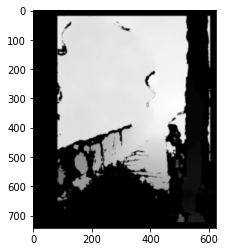

64 43


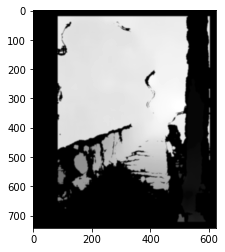

64 45


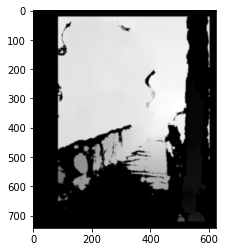

64 47


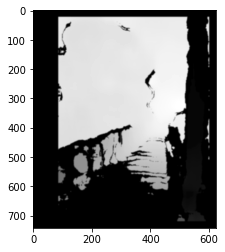

64 49


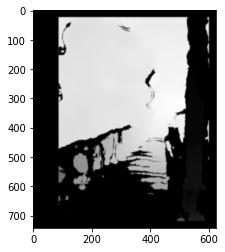

64 51


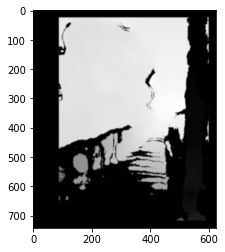

64 53


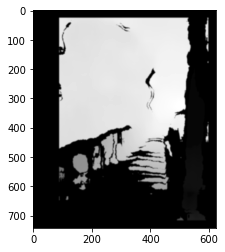

64 55


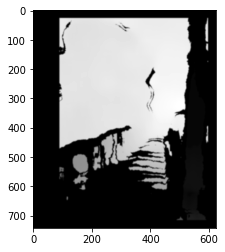

In [ ]:
for j in range(16, 65, 16):
  for i in range(5, 56, 2):
    stereo = cv2.StereoBM_create(numDisparities=j, blockSize=i)
    disparity = stereo.compute(imgL, imgR)
    disparity = disparity / np.max(disparity) * 255
    kernel = np.ones((5,5),np.uint8)
    open = cv2.GaussianBlur(disparity.copy(), (7, 7), 0)
    print(j, i)
    plt.imshow(open, 'gray')
    plt.show()

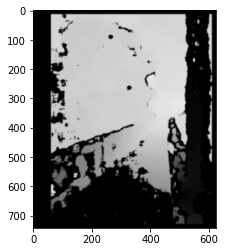

In [ ]:
stereo = cv2.StereoBM_create(numDisparities=48, blockSize=29)
disparity = stereo.compute(imgL, imgR)
disparity = disparity / np.max(disparity) * 255
kernel = np.ones((5,5),np.uint8)
open = cv2.GaussianBlur(disparity.copy(), (7, 7), 0)
plt.imshow(open, 'gray')
plt.show()

In [ ]:
cv2.imwrite('disparity.png', open)

True

In [ ]:
def depth_map(disparity, baseline, f):
  depthMap = (baseline * f) / disparity
  return depthMap

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


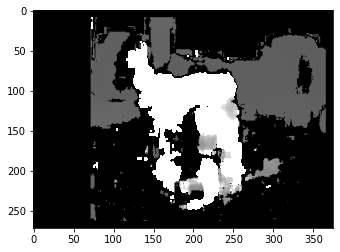

In [ ]:
dm = depth_map(disparity, 15, 10)
plt.imshow(dm, 'gray')
plt.show()

In [ ]:
def normalise_img(image):
  return image/np.max(image)

In [ ]:
@jit(nopython = True, parallel = True, cache = True)
def compute_costvolume_ncc(left_image, right_image, D, R):
  (H,W) = left_image.shape
  cv    = np.zeros((D,H,W))
  
  for d in range(0, D):
      
    for y in range(R, H - R):
      for x in range(R, W - R):
          
        l_mean = 0
        r_mean = 0
        n      = 0

        for v in range(-R, R + 1):
          for u in range(-R, R + 1):

            l_mean += left_image[y+v, x+u]
            r_mean += right_image[y+v, x+u-d]
            n      += 1

        l_mean = l_mean/n
        r_mean = r_mean/n
        
        l_r   = 0
        l_var = 0
        r_var = 0
    
        for v in range(-R, R + 1):
          for u in range(-R, R + 1):

            l = left_image[y+v, x+u]    - l_mean
            r = right_image[y+v, x+u-d] - r_mean
            
            l_r   += l*r
            l_var += l**2
            r_var += r**2
                  
          cv[d,y,x] = -l_r/np.sqrt(l_var*r_var)
  
  return np.transpose(cv, (1, 2, 0))

In [ ]:
def get_f(D, L1 = 0.025, L2 = 0.5):
  return np.full((D, D), L2) + diags([L1 - L2, -L2, L1 - L2], [-1, 0, 1], (D, D)).toarray()

In [ ]:
@jit(nopython = True, parallel = True, cache = True)
def compute_message(cv, f):
  (H,W,D) = cv.shape
  mes = np.zeros((H,W,D))

  for y in range(0, H):
    for x in range(0, W - 1):
      for t in range(0, D):
        buffer = np.zeros(D)
        for s in range(0, D):
          buffer[s] = mes[y,x,s] + cv[y,x,s] + f[t,s]
          mes[y, x+1, t] = np.min(buffer)
                
  return mes

In [ ]:
def compute_sgm(cv, f):
  (H,W,D) = cv.shape
  mes     = np.zeros((H,W,D))

  mes += compute_message(cv, f)

  mes_buffer  = np.zeros((H,W))
  mes_buffer  = compute_message(np.flip(cv, axis=1), f)
  mes        += np.flip(mes_buffer, axis=1)

  mes_buffer  = compute_message(np.transpose(cv, (1, 0, 2)), f)
  mes        += np.transpose(mes_buffer, (1, 0, 2))

  mes_buffer  = compute_message(np.flip(np.transpose(cv, (1, 0, 2)), axis=1), f)
  mes        += np.transpose(np.flip(mes_buffer, axis=1), (1, 0, 2))

  disp_map = np.zeros((H,W))
  for y in range(0, H):
    for x in range(0, W):
      disp_map[y,x] = np.argmin(cv[y,x,:] + mes[y,x,:])
    
  return disp_map

In [ ]:
cv = compute_costvolume_ncc(imgL, imgR, 64, 5)
(H,W,D) = cv.shape
f = get_f(D, 0.025, 0.5)
disp = compute_sgm(cv, f)
plt.figure()
plt.imshow(disp)
plt.show()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


ZeroDivisionError: ignored